# Sentiment Analysis Group 1
## Table of Contents
1. Data Preprocessing and Exploration  
  1.1 Data Cleaning  
  1.2 Data Preprocessing  
  1.3 Data Validation  
  1.4 Class Balancing  
  1.5 Data Splitting  
2. Sentiment Prediction  
  2.1 SVM  
  2.2 Logistic Regression  
  2.3 LSTM  
  2.4 MLP

In [ ]:
# install
! pip install langdetect -q
! pip install transformers -q
! pip install sentence-transformers -q
! pip install umap-learn -q
! pip install hdbscan -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# import
## General
import re
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import joblib

## Data Processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import langdetect
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

## Embedding
import umap
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
from tokenizers import ByteLevelBPETokenizer
import tensorflow as tf
import tensorflow_hub as hub

## Prediction
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

## Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

## Clustering
from textblob import TextBlob
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from hdbscan import HDBSCAN

## SVM and Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def download_from_gdrive(file_id, output_name):
  url = f'https://drive.google.com/uc?id={file_id}'
  output = output_name #with file type
  gdown.download(url, output, quiet=False)

## <a id="data_preprocessing">1. Data Preprocessing and Exploration</a>


In [ ]:
# download dataset
file_id = '1CHw0LZcNqNKN0sc9YwY8ug3zdtyAM67u' #https://drive.google.com/file/d/1CHw0LZcNqNKN0sc9YwY8ug3zdtyAM67u/view?usp=sharing
url = f'https://drive.google.com/uc?id={file_id}'
output = "coursera_reviews.csv"
gdown.download(url, output, quiet=False)

file_id2 = '125groP8PUYeQy8dPv2dWgFQ4z1ccXvQR'
url2 = f'https://drive.google.com/uc?id={file_id2}' #https://drive.google.com/file/d/125groP8PUYeQy8dPv2dWgFQ4z1ccXvQR/view?usp=sharing
output2 = "huggingface_reviews.csv"
gdown.download(url2, output2, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CHw0LZcNqNKN0sc9YwY8ug3zdtyAM67u
To: /content/coursera_reviews.csv
100%|██████████| 212M/212M [00:02<00:00, 92.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=125groP8PUYeQy8dPv2dWgFQ4z1ccXvQR
To: /content/huggingface_reviews.csv
100%|██████████| 17.0M/17.0M [00:00<00:00, 63.0MB/s]


'huggingface_reviews.csv'

In [ ]:
# read csv
df_coursera = pd.read_csv("coursera_reviews.csv", sep="|")
df_coursera["label"] = df_coursera[["star_ratings"]] > 3
df_coursera = df_coursera[["review", "label"]]

df_huggingface = pd.read_csv("huggingface_reviews.csv", sep = ",")
df_huggingface = df_huggingface[["review", "label"]]

df = pd.concat([df_coursera, df_huggingface], ignore_index = True, sort = False)
print(len(df))
df.head()

<ipython-input-6-1772326a6966>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_coursera = pd.read_csv("coursera_reviews.csv", sep="|")


638271


,review,label
0,The labs did not require any code changes to c...,0
1,"Good overview of key topics, but the course is...",0
2,The lectures define many important concepts in...,0
3,It would have been better to have an opportuni...,1
4,AWS and DeepLearning.AI structured the course ...,1


### <a id="data_cleaning">1.1 Data Cleaning</a>

In [ ]:
df_cleaned = df.copy()

# drop na
df_cleaned = df_cleaned.dropna(subset=["review", "label"])
df_cleaned = df_cleaned.reset_index(drop=True)

print(len(df_cleaned))
df_cleaned.head()

638271


,review,label
0,The labs did not require any code changes to c...,0
1,"Good overview of key topics, but the course is...",0
2,The lectures define many important concepts in...,0
3,It would have been better to have an opportuni...,1
4,AWS and DeepLearning.AI structured the course ...,1


### <a id="data_preprocessing">1.2 Data Preprocessing</a>

In [ ]:
# remove stopwords
df_cleaned["review"] = df_cleaned["review"].str.lower()

stop_words = set(stopwords.words('english'))
def clean_text(text):
    # converts text to lowercase
    text = text.lower()

    #replace all non-word characters (characters that are not a letter, digit, or underscore) in text with a space
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'_', '', text)

    # split the text into individual words
    words = word_tokenize(text)

    # not to remove words like "no" and "not" because it affects the sentiment of the reviews
    words = [word for word in words if ((word not in stop_words) or (word in ["no", "not"]))]

    # stemming
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]

    return ' '.join(words)

df_cleaned["review"] = df_cleaned["review"].apply(clean_text)
df_cleaned.head()

,review,label
0,lab not requir code chang complet similar free...,0
1,good overview key topic cours practic would ho...,0
2,lectur defin mani import concept easi understa...,0
3,would better opportun write code assign instea...,1
4,aw deeplearn ai structur cours three comprehen...,1


### <a id="data_validation">1.3 Data Validation</a>


Class distribution before balancing:
1    588972
0     49299
Name: label, dtype: int64


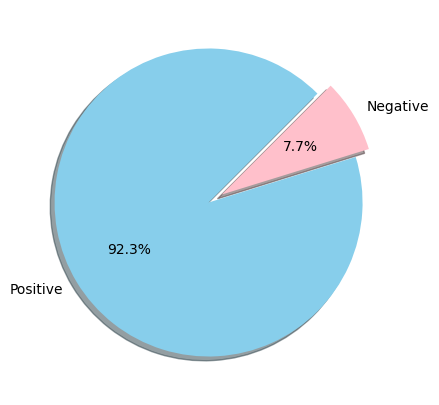

In [ ]:
# plot count of positive vs negative reviews (significant imbalance)

print("\nClass distribution before balancing:")
print(df_cleaned['label'].value_counts())

fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=df_cleaned[df_cleaned['label']==1]
neg=df_cleaned[df_cleaned['label']==0]
ck=[pos['label'].count(),neg['label'].count()]

legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%',
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

### <a id="class_balancing">1.4 Class Balancing</a>


Class distribution after balancing:
0    294486
1    294486
Name: label, dtype: int64


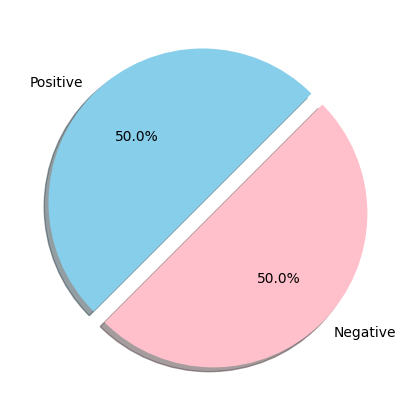

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = df_cleaned['review']
y = df_cleaned['label']

over_sampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_resampled, y_resampled = over_sampler.fit_resample(X.values.reshape(-1, 1), y)
X_resampled, y_resampled = under_sampler.fit_resample(X_resampled, y_resampled)

balanced_df = pd.DataFrame({'review': X_resampled.flatten(), 'label': y_resampled})

print("\nClass distribution after balancing:")
print(balanced_df['label'].value_counts())

fig=plt.figure(figsize=(5,5))
colors=["skyblue",'pink']
pos=balanced_df[balanced_df['label']==1]
neg=balanced_df[balanced_df['label']==0]
ck=[pos['label'].count(),neg['label'].count()]

legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%',
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

In [ ]:
balanced_df.head()

,review,label
0,lab not requir code chang complet similar free...,0
1,good overview key topic cours practic would ho...,0
2,lectur defin mani import concept easi understa...,0
3,pretti superfici coverag lab simplifi execut s...,0
4,cours materi pretti superfici lectur never rea...,0


### <a id="data_splitting">1.5 Data Splitting</a>

In [ ]:
 df_X = balanced_df["review"]
 df_y = balanced_df["label"]
# split test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_val_index, test_index in sss.split(df_X, df_y):
  df_X_train_val, df_X_test = df_X.iloc[train_val_index], df_X.iloc[test_index]
  df_y_train_val, df_y_test = df_y.iloc[train_val_index], df_y.iloc[test_index]

# split train/validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, valid_index in sss.split(df_X_train_val, df_y_train_val):
    df_X_train, df_X_val = df_X_train_val.iloc[train_index], df_X_train_val.iloc[valid_index]
    df_y_train, df_y_val = df_y_train_val.iloc[train_index], df_y_train_val.iloc[valid_index]

print("Size of training set: ", len(df_X_train))
print("Size of validation set: ", len(df_X_val))
print("Size of test set: ", len(df_X_test))

Size of training set:  288596
Size of validation set:  123684
Size of test set:  176692


# <a id="sentiment_prediction">2. Sentiment Prediction</a>

#### <a id="svm_with_word_embedding">Support Vector Machine (SVM) with Different Word Embedding Methods</a>

#### <a id="svm_word_embedding">Word Embedding</a>

##### <a id="svm_with_count_vec">CountVectorizer (Bag-of-Words)</a>

In [ ]:
count_vec = CountVectorizer()
X_train_review_us_count_vec = count_vec.fit_transform(df_X_train)
X_train_review_us_count_vec

<56424x34420 sparse matrix of type '<class 'numpy.int64'>'
	with 827123 stored elements in Compressed Sparse Row format>

In [ ]:
X_val_review_us_count_vec = count_vec.transform(df_X_val)
X_val_review_us_count_vec

<24183x34420 sparse matrix of type '<class 'numpy.int64'>'
	with 354343 stored elements in Compressed Sparse Row format>

##### <a id="svm_with_ngrams">N-grams</a>

In [ ]:
ngrams = CountVectorizer(ngram_range=(1, 3))
X_train_review_us_ngrams = ngrams.fit_transform(df_X_train)
X_train_review_us_ngrams

<56424x1181356 sparse matrix of type '<class 'numpy.int64'>'
	with 2516008 stored elements in Compressed Sparse Row format>

In [ ]:
X_val_review_us_ngrams = ngrams.transform(df_X_val)
X_val_review_us_ngrams

<24183x1181356 sparse matrix of type '<class 'numpy.int64'>'
	with 653856 stored elements in Compressed Sparse Row format>

In [ ]:
# to load presaved model
download_from_gdrive("1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC", "PRED-ngrams_transform.joblib")
ngrams = joblib.load('PRED-ngrams_transform.joblib')

Downloading...
From: https://drive.google.com/uc?id=1ThN5jOdJrVp_G2fK6t424HxooFWCsKFC
To: /content/PRED-ngrams_transform.joblib
100%|██████████| 30.5M/30.5M [00:00<00:00, 41.8MB/s]


##### <a id="svm_with_count_vec">TFIDFVectorizer</a>

In [ ]:
tfidf_vec = TfidfVectorizer()
X_train_review_us_tfidf_vec = tfidf_vec.fit_transform(df_X_train)
X_train_review_us_tfidf_vec

<56424x34420 sparse matrix of type '<class 'numpy.float64'>'
	with 827123 stored elements in Compressed Sparse Row format>

In [ ]:
X_val_review_us_tfidf_vec = tfidf_vec.transform(df_X_val)
X_val_review_us_tfidf_vec

<24183x34420 sparse matrix of type '<class 'numpy.float64'>'
	with 354343 stored elements in Compressed Sparse Row format>

##### <a id="svm_with_w2v">Word2Vec</a>

In [ ]:
def tokenize_text(text):
  if isinstance(text, (str, bytes)):
    return word_tokenize(text)
  else:
    return []

In [ ]:
X_train_review_us_tokenized = df_X_train.apply(tokenize_text)
X_val_review_us_tokenized = df_X_val.apply(tokenize_text)

In [ ]:
w2v_model_us = Word2Vec(X_train_review_us_tokenized, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# to load presaved model
download_from_gdrive("1kf_P4P7tj9u8welDb64Agyc8W0FzrBJ5", "PRED-w2v_us.joblib")
w2v_model_us = joblib.load('PRED-w2v_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1kf_P4P7tj9u8welDb64Agyc8W0FzrBJ5
To: /content/PRED-w2v_us.joblib
100%|██████████| 29.4M/29.4M [00:00<00:00, 173MB/s]


In [ ]:
wv = w2v_model.wv

In [ ]:
# vectorizing documents by averaging word embeddings
def document_vectorizer(doc, model):
  if isinstance(doc, (csr_matrix)):
    return np.zeros(model.vector_size)

  if isinstance(doc, (float)):
    return np.zeros(model.vector_size)

  # filter out words that are not in the model's vocabulary
  words = [word for word in doc if word in model.wv.key_to_index]

  # return the mean of the word vectors
  if words:
    return np.mean(model.wv[words], axis=0)
  else:
    return np.zeros(model.vector_size)

In [ ]:
# apply the vectorizer to each document in the corpus
X_train_review_us_w2v = [document_vectorizer(doc, w2v_model_us) for doc in df_X_train]
X_val_review_us_w2v = [document_vectorizer(doc, w2v_model_us) for doc in df_X_val]

##### <a id="svm_with_d2v">Doc2Vec</a>

In [ ]:
tagged_data_train_us = [TaggedDocument(words=tokenize_text(text), tags=[str(i)]) for i, text in enumerate(df_X_train)]
tagged_data_val_us = [TaggedDocument(words=tokenize_text(text), tags=[str(i)]) for i, text in enumerate(df_X_val)]

# train doc2vec model on training data
doc2vec = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4, epochs=20)
doc2vec.build_vocab(tagged_data_train_us)
doc2vec.train(tagged_data_train_us, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# encode reviews using trained doc2vec model
X_train_review_us_d2v = [doc2vec.infer_vector(doc.words) for doc in tagged_data_train_us]
X_val_review_us_d2v = [doc2vec.infer_vector(doc.words) for doc in tagged_data_val_us]

##### <a id="svm_with_bpe">Byte Pair Encoding</a>

In [ ]:
bpe_tokenizer = ByteLevelBPETokenizer()
# bpe_tokenizer.train(X_train_reviews, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]", "[UNK]"])
# bpe_trainer = bpe_tokenizer.get_trainer(special_tokens=["[PAD]", "[CLS]", "[SEP]", "[MASK]", "[UNK]"])
bpe_tokenizer.train_from_iterator(df_X_train)

bpe_encoded_X_train_us = bpe_tokenizer.encode_batch(df_X_train)
bpe_encoded_X_val_us = bpe_tokenizer.encode_batch(df_X_val)

bpe_embeddings_X_train_us = [encoded.ids for encoded in bpe_encoded_X_train_us]
bpe_embeddings_X_val_us = [encoded.ids for encoded in bpe_encoded_X_val_us]

max_length = max(max(len(ids) for ids in bpe_embeddings_X_train_us), max(len(ids) for ids in bpe_embeddings_X_val_us))
bpe_embeddings_X_train_us = [ids + [0] * (max_length - len(ids)) for ids in bpe_embeddings_X_train_us]
bpe_embeddings_X_val_us = [ids + [0] * (max_length - len(ids)) for ids in bpe_embeddings_X_val_us]

X_train_review_us_bpe = np.array(bpe_embeddings_X_train_us)
X_val_review_us_bpe = np.array(bpe_embeddings_X_val_us)

##### <a id="svm_with_use">Universal Sentence Encoder</a>

In [ ]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embed = hub.load(use_url)

X_train_review_us_use = np.array(use_embed(df_X_train))
X_val_review_us_use = np.array(use_embed(df_X_val))

##### <a id="svm_with_bert">BERT (using pre-trained model)</a>

- Undersampled

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenized_text_train = [tokenizer(text, return_tensors="pt", padding=True, truncation=True) for text in df_X_train]

bert_embeddings_train = [model(**inputs).last_hidden_state.mean(dim=1).detach().numpy() for inputs in tokenized_text_train]

X_train_reviews_bert = np.vstack(bert_embeddings_train)

In [ ]:
tokenized_text_val = [tokenizer(text, return_tensors="pt", padding=True, truncation=True) for text in df_X_val]

bert_embeddings_val = [model(**inputs).last_hidden_state.mean(dim=1).detach().numpy() for inputs in tokenized_text_val]

X_val_reviews_bert = np.vstack(bert_embeddings_val)

In [ ]:
# Download the dataset
file_id = '1wWUySRzo0dy3pkthih5ecX0V7V6qtwbi'
url = f'https://drive.google.com/uc?id={file_id}'
output = "word_embedding__bert__X_train_reviews_bert.csv"
gdown.download(url, output, quiet=False)

X_train_reviews_bert = np.load('word_embedding__bert__X_train_reviews_bert.npy')

Downloading...
From: https://drive.google.com/uc?id=1wWUySRzo0dy3pkthih5ecX0V7V6qtwbi
To: /content/word_embedding__bert__X_train_reviews_bert.csv
100%|██████████| 173M/173M [00:07<00:00, 22.1MB/s]


In [ ]:
# to load pre-processed df
# Download the dataset
file_id = '15E93Y9lsFXsj5cOccy6pHNJaJMMvRkwI'
url = f'https://drive.google.com/uc?id={file_id}'
output = "word_embedding__bert__X_val_reviews_bert.csv"
gdown.download(url, output, quiet=False)

X_val_reviews_bert = np.load('word_embedding__bert__X_val_reviews_bert.npy')

Downloading...
From: https://drive.google.com/uc?id=15E93Y9lsFXsj5cOccy6pHNJaJMMvRkwI
To: /content/word_embedding__bert__X_val_reviews_bert.csv
100%|██████████| 74.3M/74.3M [00:04<00:00, 17.7MB/s]


#### <a id="fitting_models">Fitting Models</a>

In [ ]:
def get_scores(actual_y, pred_y, pred_proba_y):
    print("Accuracy Score:", accuracy_score(actual_y, pred_y))
    print("Precision Score:", precision_score(actual_y, pred_y))
    print("Recall Score:", recall_score(actual_y, pred_y))
    print("F1 Score:", f1_score(actual_y, pred_y))
    print("ROC AUC Score:", roc_auc_score(actual_y, pred_proba_y))
    print("Confusion Matrix:\n", confusion_matrix(actual_y, pred_y))

A simple but well-performing model according to our research, Support Vector Machine (SVM), has been used to compare the performance of the different embedding methods.

##### CountVectorizer (BoW)

In [ ]:
svc_clf__count_vec_us = SVC(probability=True)
svc_clf__count_vec_us.fit(X_train_review_us_count_vec, df_y_train)

SVC(probability=True)

In [ ]:
# to load presaved model
download_from_gdrive("1Cqp9p_VDQbBAt3IbPkYVwf64Wewzv8GN", "PRED-svc_clf__count_vec_us.joblib")
svc_clf__count_vec_us = joblib.load('PRED-svc_clf__count_vec_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1Cqp9p_VDQbBAt3IbPkYVwf64Wewzv8GN
To: /content/PRED-svc_clf__count_vec_us.joblib
100%|██████████| 7.10M/7.10M [00:00<00:00, 24.9MB/s]


In [ ]:
y_pred__svc__count_vec__train_us = svc_clf__count_vec_us.predict(X_train_review_us_count_vec)
y_pred_proba__svc__count_vec__train_us = svc_clf__count_vec_us.predict_proba(X_train_review_us_count_vec)[:, 1]

In [ ]:
y_pred__svc__count_vec__val_us = svc_clf__count_vec_us.predict(X_val_review_us_count_vec)
y_pred_proba__svc__count_vec__val_us = svc_clf__count_vec_us.predict_proba(X_val_review_us_count_vec)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__count_vec__train_us, y_pred_proba__svc__count_vec__train_us)

Accuracy Score: 0.9288068906848149
Precision Score: 0.9229513113606825
Recall Score: 0.9420068027210884
F1 Score: 0.9323817058595789
ROC AUC Score: 0.9664278338629708
Confusion Matrix:
 [[24712  2312]
 [ 1705 27695]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__count_vec__val_us, y_pred_proba__svc__count_vec__val_us)

Accuracy Score: 0.8691642889633213
Precision Score: 0.8775608194622279
Recall Score: 0.8703174603174603
F1 Score: 0.8739241313356709
ROC AUC Score: 0.9321907824685602
Confusion Matrix:
 [[10053  1530]
 [ 1634 10966]]


##### N-grams

In [ ]:
svc_clf__ngrams_us = SVC(probability=True)
svc_clf__ngrams_us.fit(X_train_review_us_ngrams, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
# joblib.dump(svc_clf__ngrams_us, 'PRED-svc_clf__ngrams_us.joblib')

['PRED-svc_clf__ngrams_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t", "PRED-svc_clf__ngrams_us.joblib")
svc_clf__ngrams_us = joblib.load('PRED-svc_clf__ngrams_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1lC7rJmD1fIyqdCnODXkVI4fLa_SLhp-t
To: /content/PRED-svc_clf__ngrams_us.joblib
100%|██████████| 23.4M/23.4M [00:00<00:00, 37.9MB/s]


In [ ]:
y_pred__svc__ngrams__train_us = svc_clf__ngrams_us.predict(X_train_review_us_ngrams)
y_pred_proba__svc__ngrams__train_us = svc_clf__ngrams_us.predict_proba(X_train_review_us_ngrams)[:, 1]

In [ ]:
y_pred__svc__ngrams__val_us = svc_clf__ngrams_us.predict(X_val_review_us_ngrams)
y_pred_proba__svc__ngrams__val_us = svc_clf__ngrams_us.predict_proba(X_val_review_us_ngrams)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__ngrams__train_us, y_pred_proba__svc__ngrams__train_us)

Accuracy Score: 0.9458740961293067
Precision Score: 0.9374667906482466
Recall Score: 0.9601700680272108
F1 Score: 0.9486826186315366
ROC AUC Score: 0.9753593889080203
Confusion Matrix:
 [[25141  1883]
 [ 1171 28229]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__ngrams__val_us, y_pred_proba__svc__ngrams__val_us)

Accuracy Score: 0.8728032088657321
Precision Score: 0.8609216310444141
Recall Score: 0.9015079365079365
F1 Score: 0.8807474606497636
ROC AUC Score: 0.9350059337096374
Confusion Matrix:
 [[ 9748  1835]
 [ 1241 11359]]


##### TFIDFVectorizer

In [ ]:
svc_clf__tfidf_us = SVC(probability=True)
svc_clf__tfidf_us.fit(X_train_review_us_tfidf_vec, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
joblib.dump(svc_clf__tfidf_us, 'PRED-svc_clf__tfidf_us.joblib')

['PRED-svc_clf__tfidf_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("1p_MCQSc5MstJ6XIzcbCvSd6I3tmcp7Ko", "PRED-svc_clf__tfidf_us.joblib")
svc_clf__tfidf_us = joblib.load('PRED-svc_clf__tfidf_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1p_MCQSc5MstJ6XIzcbCvSd6I3tmcp7Ko
To: /content/PRED-svc_clf__tfidf_us.joblib
100%|██████████| 5.68M/5.68M [00:00<00:00, 124MB/s]


In [ ]:
y_pred__svc__tfidf_vec__train_us = svc_clf__tfidf_us.predict(X_train_review_us_tfidf_vec)
y_pred_proba__svc__tfidf_vec__train_us = svc_clf__tfidf_us.predict_proba(X_train_review_us_tfidf_vec)[:, 1]

In [ ]:
y_pred__svc__tfidf_vec__val_us = svc_clf__tfidf_us.predict(X_val_review_us_tfidf_vec)
y_pred_proba__svc__tfidf_vec__val_us = svc_clf__tfidf_us.predict_proba(X_val_review_us_tfidf_vec)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__tfidf_vec__train_us, y_pred_proba__svc__tfidf_vec__train_us)

Accuracy Score: 0.95705728058982
Precision Score: 0.9566645224633511
Recall Score: 0.9611224489795919
F1 Score: 0.9588883044606953
ROC AUC Score: 0.984009062365325
Confusion Matrix:
 [[25744  1280]
 [ 1143 28257]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__tfidf_vec__val_us, y_pred_proba__svc__tfidf_vec__val_us)

Accuracy Score: 0.8835132117603275
Precision Score: 0.887937187723055
Recall Score: 0.8885714285714286
F1 Score: 0.8882541949303819
ROC AUC Score: 0.9405217758921464
Confusion Matrix:
 [[10170  1413]
 [ 1404 11196]]


##### Word2Vec

In [ ]:
svc_clf__w2v_us = SVC(probability=True)
svc_clf__w2v_us.fit(X_train_review_us_w2v, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
# joblib.dump(svc_clf, 'PRED-svc_clf__w2v_us.joblib')

['PRED-svc_clf__w2v_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("1y6x_ZsmmNz_zFapwmF_5hBr2EL24_z5B", "PRED-svc_clf__w2v_us.joblib")
svc_clf__w2v_us = joblib.load('PRED-svc_clf__w2v_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1y6x_ZsmmNz_zFapwmF_5hBr2EL24_z5B
To: /content/PRED-svc_clf__w2v_us.joblib
100%|██████████| 37.7M/37.7M [00:01<00:00, 36.4MB/s]


In [ ]:
y_pred__svc__w2v__train_us = svc_clf__w2v_us.predict(X_train_review_us_w2v)
y_pred_proba__svc__w2v__train_us = svc_clf__w2v_us.predict_proba(X_train_review_us_w2v)[:, 1]

In [ ]:
y_pred__svc__w2v__val_us = svc_clf__w2v_us.predict(X_val_review_us_w2v)
y_pred_proba__svc__w2v__val_us = svc_clf__w2v_us.predict_proba(X_val_review_us_w2v)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__w2v__train_us, y_pred_proba__svc__w2v__train_us)

Accuracy Score: 0.6443422100327346
Precision Score: 0.7144833948339483
Recall Score: 0.5268707482993197
F1 Score: 0.6064996084573218
ROC AUC Score: 0.7021576749822186
Confusion Matrix:
 [[20925  6190]
 [13910 15490]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__w2v__val_us, y_pred_proba__svc__w2v__val_us)

Accuracy Score: 0.6389083852854961
Precision Score: 0.7080094991364422
Recall Score: 0.5205555555555555
F1 Score: 0.599981705085986
ROC AUC Score: 0.6985135626117469
Confusion Matrix:
 [[8916 2705]
 [6041 6559]]


##### Doc2Vec

In [ ]:
svc_clf__d2v_us = SVC(probability=True)
svc_clf__d2v_us.fit(X_train_review_us_d2v, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
# joblib.dump(svc_clf__d2v_us, 'PRED-svc_clf__d2v_us.joblib')

['PRED-svc_clf__d2v_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("1FkBFnNVQcLUIi3e2o6-k_5QvWxxZhAfz", "PRED-svc_clf__d2v_us.joblib")
svc_clf__d2v_us = joblib.load('PRED-svc_clf__d2v_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1FkBFnNVQcLUIi3e2o6-k_5QvWxxZhAfz
To: /content/PRED-svc_clf__d2v_us.joblib
100%|██████████| 25.1M/25.1M [00:00<00:00, 30.8MB/s]


In [ ]:
y_pred__svc__d2v__train_us = svc_clf__d2v_us.predict(X_train_review_us_d2v)
y_pred_proba__svc__d2v__train_us = svc_clf__d2v_us.predict_proba(X_train_review_us_d2v)[:, 1]

In [ ]:
y_pred__svc__d2v__val_us = svc_clf__d2v_us.predict(X_val_review_us_d2v)
y_pred_proba__svc__d2v__val_us = svc_clf__d2v_us.predict_proba(X_val_review_us_d2v)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__d2v__train_us, y_pred_proba__svc__d2v__train_us)

Accuracy Score: 0.8592620161633348
Precision Score: 0.8357900666604074
Recall Score: 0.9083673469387755
F1 Score: 0.8705686763483449
ROC AUC Score: 0.9235953302280058
Confusion Matrix:
 [[21777  5247]
 [ 2694 26706]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__d2v__val_us, y_pred_proba__svc__d2v__val_us)

Accuracy Score: 0.804159947070256
Precision Score: 0.8069476971116315
Recall Score: 0.8203968253968253
F1 Score: 0.813616686343959
ROC AUC Score: 0.8775600702452553
Confusion Matrix:
 [[ 9110  2473]
 [ 2263 10337]]


##### Byte Pair Encoding (BPE)

In [ ]:
svc_clf__bpe_us = SVC(probability=True)
svc_clf__bpe_us.fit(X_train_review_us_bpe, df_y_train)

In [ ]:
# to load presaved model
download_from_gdrive("1vDTej9aFDeu0pCmR9V1aYHuvX0bNdNM7", "PRED-svc_clf__bpe_us.joblib")
svc_clf__bpe_us = joblib.load('PRED-svc_clf__bpe_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1vDTej9aFDeu0pCmR9V1aYHuvX0bNdNM7
To: /content/PRED-svc_clf__bpe_us.joblib
100%|██████████| 233M/233M [00:02<00:00, 103MB/s] 


In [ ]:
y_pred__svc__bpe__train_us = svc_clf__bpe_us.predict(X_train_review_us_bpe)
y_pred_proba__svc__bpe__train_us = svc_clf__bpe_us.predict_proba(X_train_review_us_bpe)[:, 1]

In [ ]:
y_pred__svc__bpe__val_us = svc_clf__bpe_us.predict(X_val_review_us_bpe)
y_pred_proba__svc__bpe__val_us = svc_clf__bpe_us.predict_proba(X_val_review_us_bpe)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__bpe__train_us, y_pred_proba__svc__bpe__train_us)

Accuracy Score: 0.6821210832269956
Precision Score: 0.6636218314683717
Recall Score: 0.7907482993197279
F1 Score: 0.7216290042215048
ROC AUC Score: 0.7449204498999127
Confusion Matrix:
 [[15240 11784]
 [ 6152 23248]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__bpe__val_us, y_pred_proba__svc__bpe__val_us)

Accuracy Score: 0.6354877393210107
Precision Score: 0.6312322307745649
Recall Score: 0.7224603174603175
F1 Score: 0.6737722512120202
ROC AUC Score: 0.690787391620725
Confusion Matrix:
 [[6265 5318]
 [3497 9103]]


##### Universal Sentence Encoder (USE)



In [ ]:
svc_clf__use_us = SVC(probability=True)
svc_clf__use_us.fit(X_train_review_us_use, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
joblib.dump(svc_clf__use_us, 'PRED-svc_clf__use_us.joblib')

['PRED-svc_clf__use_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("1liWZNRHz0HFFetvHno-5tFIFR3RF-jeW", "PRED-svc_clf__use_us.joblib")
svc_clf__use_us = joblib.load('PRED-svc_clf__use_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=1liWZNRHz0HFFetvHno-5tFIFR3RF-jeW
To: /content/PRED-svc_clf__use_us.joblib
100%|██████████| 91.1M/91.1M [00:03<00:00, 23.9MB/s]


In [ ]:
y_pred__svc__use__train_us = svc_clf__use_us.predict(X_train_review_us_use)
y_pred_proba__svc__use__train_us = svc_clf__use_us.predict_proba(X_train_review_us_use)[:, 1]

In [ ]:
y_pred__svc__use__val_us = svc_clf__use_us.predict(X_val_review_us_use)
y_pred_proba__svc__use__val_us = svc_clf__use_us.predict_proba(X_val_review_us_use)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__use__train_us, y_pred_proba__svc__use__train_us)

Accuracy Score: 0.9183503473699135
Precision Score: 0.9193248317153199
Recall Score: 0.9244217687074829
F1 Score: 0.9218662551091362
ROC AUC Score: 0.9680098680235861
Confusion Matrix:
 [[24639  2385]
 [ 2222 27178]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__use__val_us, y_pred_proba__svc__use__val_us)

Accuracy Score: 0.8708596948269446
Precision Score: 0.8755051905856248
Recall Score: 0.8768253968253968
F1 Score: 0.876164796383679
ROC AUC Score: 0.9327849790812753
Confusion Matrix:
 [[10012  1571]
 [ 1552 11048]]


###### BERT (using pre-trained model)

In [ ]:
svc_clf__bert_us = SVC(probability=True)
svc_clf__bert_us.fit(X_train_reviews_bert, df_y_train)

SVC(probability=True)

In [ ]:
# to save model
joblib.dump(svc_clf__bert_us, 'PRED-svc_clf__bert_us.joblib')

['PRED-svc_clf__bert_us.joblib']

In [ ]:
# to load presaved model
download_from_gdrive("19lrIR7U5xfudavVz7JNHy5TKzf_WrizV", "PRED-svc_clf__bert_us.joblib")
svc_clf__bert_us = joblib.load('PRED-svc_clf__bert_us.joblib')

Downloading...
From: https://drive.google.com/uc?id=19lrIR7U5xfudavVz7JNHy5TKzf_WrizV
To: /content/PRED-svc_clf__bert_us.joblib
100%|██████████| 130M/130M [00:06<00:00, 20.7MB/s]


In [ ]:
y_pred__svc__bert__train_us = svc_clf__bert_us.predict(X_train_reviews_bert)
y_pred_proba__svc__bert__train_us = svc_clf__bert_us.predict_proba(X_train_reviews_bert)[:, 1]

In [ ]:
y_pred__svc__bert__val_us = svc_clf__bert_us.predict(X_val_reviews_bert)
y_pred_proba__svc__bert__val_us = svc_clf__bert_us.predict_proba(X_val_reviews_bert)[:, 1]

In [ ]:
# train
get_scores(df_y_train, y_pred__svc__bert__train_us, y_pred_proba__svc__bert__train_us)

Accuracy Score: 0.8844995037572664
Precision Score: 0.8865763421968442
Recall Score: 0.8925170068027211
F1 Score: 0.8895367561062427
ROC AUC Score: 0.9440883877973925
Confusion Matrix:
 [[23667  3357]
 [ 3160 26240]]


In [ ]:
# val
get_scores(df_y_val, y_pred__svc__bert__val_us, y_pred_proba__svc__bert__val_us)

Accuracy Score: 0.8631683413968491
Precision Score: 0.867262234168709
Recall Score: 0.8706349206349207
F1 Score: 0.868945304764545
ROC AUC Score: 0.9297261688928357
Confusion Matrix:
 [[ 9904  1679]
 [ 1630 10970]]


##### <a id="svm_with_count_vec">TFIDFVectorizer</a>

In [ ]:
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(df_X_train)
y_train_tfidf = tfidf_vec.fit_transform(df_y_train)

AttributeError: ignored

### <a id="SVM"> Support Vector Machine (SVM)</a>

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# loss = hinge means soft margin linear SVM
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

clf.fit(X_train_tfidf, y_train_tfidf)
y_pred = clf.predict(df_X_test)

# evaluation
accuracy = accuracy_score(df_y_test, y_pred)
report = classification_report(df_y_test, y_pred)
precision_score = precision_score(df_y_test, y_pred)
recall_score = recall_score(df_y_test, y_pred)

print(f"Accuracy of SVM using SGD: {accuracy}")
print(f"Precision of SVM using SGD: {precision_score}")
print(f"Recall of SVM using SGD: {recall_score}")
print(f"Classification Report of SVM using SGD:\n{report}")

NameError: ignored

### <a id="SVM"> Support Vector Machine (SVM) with Hyperparameter Tuning </a>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'penalty': ['l2'],
    'max_iter': [500, 1000],
    'learning_rate': ['optimal', 'constant', 'adaptive', 'invscaling'],
    'eta0': [0.01, 0.1, 0.5],
    'loss': ['hinge']
}

sgd_classifier = SGDClassifier()
grid_search_sgd = GridSearchCV(sgd_classifier, param_grid, cv=5, scoring='accuracy')

# train SGDClassifier on the resampled data with hyperparameter tuning
grid_search_sgd.fit(X_train_tfidf, y_train_tfidf)

y_pred = grid_search_sgd.predict(df_X_test)

# evaluation
accuracy = accuracy_score(df_y_test, y_pred)
report = classification_report(df_y_test, y_pred)
precision_score = precision_score(df_y_test, y_pred)
recall_score = recall_score(df_y_test, y_pred)

print(f"Accuracy of SVM using SGD (Hyperparameter Tuning): {accuracy}")
print(f"Precision of SVM using SGD (Hyperparameter Tuning): {precision_score}")
print(f"Recall of SVM using SGD (Hyperparameter Tuning): {recall_score}")
print(f"Classification Report of SVM using SGD (Hyperparameter Tuning):\n{report}")

Accuracy of SVM using SGD: 0.8769143752175427
Precision of SVM using SGD: 0.8921478484737035
Recall of SVM using SGD: 0.8542125187076327
Classification Report of SVM using SGD:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11625
           1       0.89      0.85      0.87     11359

    accuracy                           0.88     22984
   macro avg       0.88      0.88      0.88     22984
weighted avg       0.88      0.88      0.88     22984



### <a id="LR"> Logistic Regression (LR)</a>

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# use log loss means logistic regression
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

clf.fit(X_train_tfidf, y_train_tfidf)
y_pred = clf.predict(df_X_test)

# evaluation
accuracy = accuracy_score(df_y_test, y_pred)
report = classification_report(df_y_test, y_pred)
precision_score = precision_score(df_y_test, y_pred)
recall_score = recall_score(df_y_test, y_pred)

print(f"Accuracy of Logistic Regression: {accuracy}")
print(f"Precision of Logistic Regression: {precision_score}")
print(f"Recall of Logistic Regression: {recall_score}")
print(f"Classification Report of Logistic Regression:\n{report}")

Accuracy of Logistic Regression: 0.8692568743473721
Precision of Logistic Regression: 0.8799345097325814
Recall of Logistic Regression: 0.8516594770666432
Classification Report of Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11625
           1       0.88      0.85      0.87     11359

    accuracy                           0.87     22984
   macro avg       0.87      0.87      0.87     22984
weighted avg       0.87      0.87      0.87     22984



### <a id="LR"> Logistic Regression (LR) with Hyperparameter Tuning</a>

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2'],
    'max_iter': [500, 1000],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.1, 0.5]
}

clf = SGDClassifier(loss='log', fit_intercept=True, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

grid_search_lr = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_tfidf, y_train_tfidf)

best_params = grid_search_lr.best_params_
best_clf_lr = grid_search_lr.best_estimator_

# use best estimator to make predictions
y_pred = best_clf_lr.predict(df_X_test)

# evaluate
accuracy = accuracy_score(df_y_test, y_pred)
report = classification_report(df_y_test, y_pred)

print(f"Accuracy of Logistic Regression (Hyperparameter Tuning): {accuracy}")
print(f"Precision of Logistic Regression (Hyperparameter Tuning): {precision_score}")
print(f"Recall of Logistic Regression (Hyperparameter Tuning): {recall_score}")
print(f"Classification Report of Logistic Regression (Hyperparameter Tuning):\n{report}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy of Logistic Regression (Hyperparameter Tuning): 0.870692655760529
Precision of Logistic Regression (Hyperparameter Tuning): <function precision_score at 0x7c51f9376560>
Recall of Logistic Regression (Hyperparameter Tuning): <function recall_score at 0x7c51f93765f0>
Classification Report of Logistic Regression (Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11625
           1       0.88      0.85      0.87     11359

    accuracy                           0.87     22984
   macro avg       0.87      0.87      0.87     22984
weighted avg       0.87      0.87      0.87     22984



### <a id="mlp"> Multilayer Perceptron (MLP)</a>

#### Word2Vec

In [ ]:
# tokenize sentences and train Word2Vec model
x_train_words = df_X_train.apply(word_tokenize).tolist()
x_val_words = df_X_val.apply(word_tokenize).tolist()
x_test_words = df_X_test.apply(word_tokenize).tolist()

model = Word2Vec(sentences = x_train_words, vector_size = 100, window = 5, min_count = 1, workers = 4)
model.save("word2vec_mlp.bin")
wv = model.wv

# word embedding function
def get_sentence_vectors(sentences):
  vectors = []
  for sentence in sentences:
    sentence_vectors = [wv[word] for word in sentence if word in wv]
    if len(sentence_vectors) == 0:
      vectors.append([0]*100)
    else:
      vectors.append(np.mean(sentence_vectors, axis = 0))

  return vectors

# word embedding for each review in dataset
x_train_vectors = get_sentence_vectors(x_train_words)
x_val_vectors = get_sentence_vectors(x_val_words)
x_test_vectors = get_sentence_vectors(x_test_words)

#### MLP Model

In [ ]:
# initialize MLP model
class MLP(nn.Module):
  def __init__(self, vector_length, hidden_size2, hidden_size3, hidden_size4, output_dim, dropout):
    super(MLP, self).__init__()

    # Defining & Initializing all the layers in our network
    self.relu = nn.ReLU() # ReLU activation function
    self.dropout = nn.Dropout(dropout) # Dropout function
    self.fc1 = nn.Linear(vector_length, hidden_size2) # First dense layer
    self.fc2 = nn.Linear(hidden_size2, hidden_size3) # Second dense layer
    self.fc3 = nn.Linear(hidden_size3, hidden_size4) # Third dense layer
    self.fc4 = nn.Linear(hidden_size4, output_dim) # Output layer

  def forward(self, x):
    x = torch.flatten(x, 1) # Flatten
    x = self.relu(self.fc1(x)) # Apply ReLU activation function to output of first layer
    x = self.dropout(x) # Drop some nodes
    x = self.relu(self.fc2(x)) # Apply ReLU activation function to output of second layer
    x = self.dropout(x) # Drop some nodes
    x = self.relu(self.fc3(x)) # Apply ReLU activation function to output of third layer
    x = self.dropout(x) # Drop some nodes
    x = self.fc4(x)
    return x

#### Hyperparameters

In [ ]:
class Args:
  epochs = 10
  lr = 0.01
  use_cuda = True
  gamma = 0.7
  log_interval = 10
  seed = 0

args = Args()

#### Train & Test Functions

In [ ]:
# Train function
def train(args, model, device, train_loader, optimizer, epoch):
  model.train()

  for batch_no, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    target = target.long()

    optimizer.zero_grad()
    output = model(data)

    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    if batch_no % args.log_interval ==0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_no*len(data), len(train_loader.dataset), 100. * batch_no/len(train_loader), loss.item()))

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  predictions = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim = 1, keepdim = True)
      predictions.append(pred)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
  return (correct, predictions)

#### Data Loading

In [ ]:
# convert data to tensor
x_train_tensor = torch.tensor(x_train_vectors)
y_train_tensor = torch.tensor(df_y_train.values)
x_val_tensor = torch.tensor(x_val_vectors)
y_val_tensor = torch.tensor(df_y_val.values)
x_test_tensor = torch.tensor(x_test_vectors)
y_test_tensor = torch.tensor(df_y_test.values)

# Saving the datasets
# torch.save(x_train_tensor, "x_train_tensor.pt")
# torch.save(y_train_tensor, "y_train_tensor.pt")
# torch.save(x_val_tensor, "x_val_tensor.pt")
# torch.save(y_val_tensor, "y_val_tensor.pt")
# torch.save(x_test_tensor, "x_test_tensor.pt")
# torch.save(y_test_tensor, "y_test_tensor.pt")

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# dataloader
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

<ipython-input-25-f946527786c7>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x_train_tensor = torch.tensor(x_train_vectors)


#### Model Training

In [ ]:
torch.manual_seed(0)

device = torch.device("cuda")
model = MLP(100, 128, 128, 128, 2, 0.3).to(device)

optimizer = optim.Adadelta(model.parameters(), lr = args.lr)
scheduler = StepLR(optimizer, step_size = 1, gamma = args.gamma)

# Model training
acc = 0
for epoch in range(1, args.epochs + 1):
  train(args, model, device, train_loader, optimizer, epoch)
  acc_ = test(model, device, val_loader)[0]
  if acc_>acc or acc_ == acc:
    acc = acc_
    torch.save(model.state_dict(), "MLP.pt")

  scheduler.step()
print(acc)

Train Epoch: 1 [0/288596 (0%)]	Loss: 0.693782
Train Epoch: 1 [1280/288596 (0%)]	Loss: 0.693584
Train Epoch: 1 [2560/288596 (1%)]	Loss: 0.690542
Train Epoch: 1 [3840/288596 (1%)]	Loss: 0.691423
Train Epoch: 1 [5120/288596 (2%)]	Loss: 0.693509
Train Epoch: 1 [6400/288596 (2%)]	Loss: 0.694611
Train Epoch: 1 [7680/288596 (3%)]	Loss: 0.690860
Train Epoch: 1 [8960/288596 (3%)]	Loss: 0.692189
Train Epoch: 1 [10240/288596 (4%)]	Loss: 0.692836
Train Epoch: 1 [11520/288596 (4%)]	Loss: 0.685857
Train Epoch: 1 [12800/288596 (4%)]	Loss: 0.690412
Train Epoch: 1 [14080/288596 (5%)]	Loss: 0.689040
Train Epoch: 1 [15360/288596 (5%)]	Loss: 0.684946
Train Epoch: 1 [16640/288596 (6%)]	Loss: 0.687471
Train Epoch: 1 [17920/288596 (6%)]	Loss: 0.691391
Train Epoch: 1 [19200/288596 (7%)]	Loss: 0.688882
Train Epoch: 1 [20480/288596 (7%)]	Loss: 0.686205
Train Epoch: 1 [21760/288596 (8%)]	Loss: 0.688126
Train Epoch: 1 [23040/288596 (8%)]	Loss: 0.689317
Train Epoch: 1 [24320/288596 (8%)]	Loss: 0.685117
Train Epoch

#### Model Testing

In [ ]:
y_test_labels = []

for data, target in test_loader:
  target.cpu()
  target = target.numpy()
  y_test_labels.append(target)

y_test_pred = test(model, device, test_loader)[1]
y_test_pred = [label for sublist in y_test_pred for label in sublist]
y_test_pred = torch.tensor(y_test_pred, device = device)
y_test_pred = y_test_pred.cpu().numpy()
y_test_labels = [label for sublist in y_test_labels for label in sublist]

print(classification_report(y_test_labels, y_test_pred))


Test set: Average loss: 0.0000, Accuracy: 153423/176692 (87%)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     88346
           1       0.88      0.86      0.87     88346

    accuracy                           0.87    176692
   macro avg       0.87      0.87      0.87    176692
weighted avg       0.87      0.87      0.87    176692



### Final Model: SVM with TFIDFVectorizer

In [ ]:
X_test_review_us_tfidf_vec = tfidf_vec.transform(df_X_test)

In [ ]:
y_pred__svc__tfidf_vec__test_us = svc_clf__tfidf_us.predict(X_test_review_us_tfidf_vec)
y_pred_proba__svc__tfidf_vec__test_us = svc_clf__tfidf_us.predict_proba(X_test_review_us_tfidf_vec)[:, 1]

In [ ]:
# test
get_scores(df_y_test, y_pred__svc__tfidf_vec__test_us, y_pred_proba__svc__tfidf_vec__test_us)

Accuracy Score: 0.8845630590210438
Precision Score: 0.8889197290995892
Recall Score: 0.8896111111111111
F1 Score: 0.8892652857222191
ROC AUC Score: 0.9392515696030834
Confusion Matrix:
 [[14546  2001]
 [ 1987 16013]]
